In [1]:
from fastai.vision.all import *
from self_supervised.augmentations import *
from self_supervised.layers import *
from self_supervised.moco import *
from fastai.callback.wandb import WandbCallback
import wandb

## Pretraining

In [2]:
sqrmom=0.99
mom=0.95
beta=0.
eps=1e-4
opt_func = partial(ranger, mom=mom, sqr_mom=sqrmom, eps=eps, beta=beta)

In [3]:
def get_dls(size, bs, workers=None):
    path = URLs.IMAGEWANG_160 if size <= 160 else URLs.IMAGEWANG
    source = untar_data(path)
    
    files = get_image_files(source)
    tfms = [[PILImage.create, ToTensor, RandomResizedCrop(size, min_scale=1.)], 
            [parent_label, Categorize()]]
    
    dsets = Datasets(files, tfms=tfms, splits=RandomSplitter(valid_pct=0.1)(files))
    
    batch_tfms = [IntToFloatTensor]
    dls = dsets.dataloaders(bs=bs, num_workers=workers, after_batch=batch_tfms)
    return dls

In [4]:
bs=128
resize, size = 256, 224

In [5]:
arch = "xresnet34"
encoder = create_encoder(arch, pretrained=False, n_in=3)

In [6]:
xtra_config = {"Arch":arch, "Resize":resize, "Size":size, "Algorithm":"MoCo"}
wandb.init(project="self-supervised-imagewang", config=xtra_config);

Failed to query for notebook name, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable
wandb: Currently logged in as: keremturgutlu (use `wandb login --relogin` to force relogin)
wandb: wandb version 0.10.20 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


In [7]:
dls = get_dls(resize, bs)

In [8]:
queue_size = dls.bs*(2**5)

In [9]:
model = create_moco_model(encoder, n_in=3)

In [10]:
learn = Learner(dls, model,
                cbs=[MOCO(K=queue_size,
                          aug_func=get_batch_augs,
                          rotate=True,
                          rotate_deg=10,
                          jitter=True,
                          bw=True,
                          blur=False
                          ),
                     TerminateOnNaNCallback(),
                     WandbCallback(log_preds=False,log_model=False)
                     ])

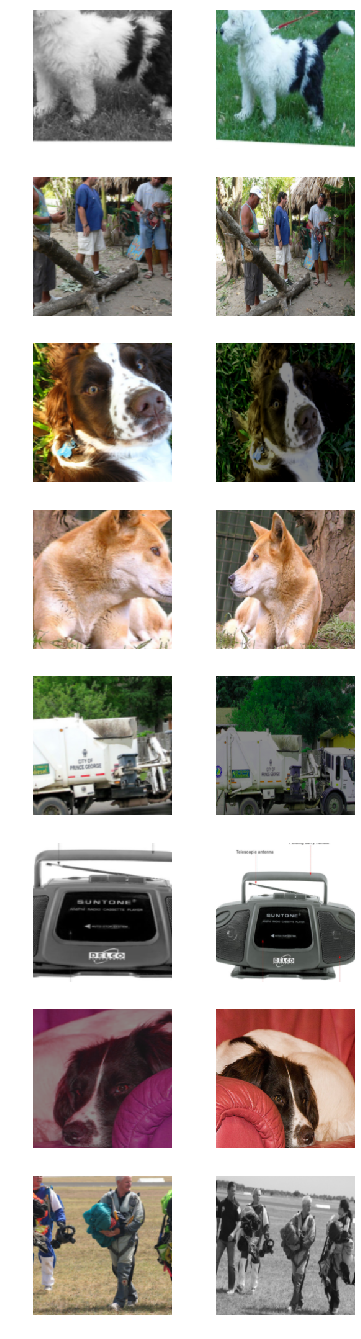

In [11]:
b = dls.one_batch()
learn._split(b)
learn.moco.show(n=8)

In [11]:
learn.moco.K, learn.moco.temp, learn.moco.m

(4096, 0.07, 0.999)

In [12]:
learn.to_fp16();

In [13]:
# learn.lr_find()

In [14]:
lr=1e-2
wd=1e-2
epochs=200

In [ ]:
learn.unfreeze()
learn.fit_one_cycle(epochs, lr, wd=wd, pct_start=0.5)

epoch,train_loss,valid_loss,time
0,7.013557,6.977848,01:27
1,6.638880,6.786009,01:27
2,6.397030,6.448298,01:25
3,6.055981,6.173647,01:25
4,5.826508,5.649175,01:24
5,5.469044,5.658872,01:25
6,5.260603,5.519609,01:26
7,4.947240,5.296878,01:26
8,4.702875,5.129349,01:26
9,4.579508,4.879913,01:26


In [ ]:
wandb.finish()

In [ ]:
save_name = f'moco_iwang_sz{size}_epc{epochs}'
learn.save(save_name)
torch.save(learn.model.encoder.state_dict(), learn.path/learn.model_dir/f'{save_name}_encoder.pth')

In [ ]:
learn.recorder.plot_loss()

## Downstream Task

In [19]:
bs, size

(128, 224)

In [20]:
def get_dls(size, bs, workers=None):
    path = URLs.IMAGEWANG_160 if size <= 160 else URLs.IMAGEWANG
    source = untar_data(path)
    files = get_image_files(source, folders=['train', 'val'])
    splits = GrandparentSplitter(valid_name='val')(files)
    
    item_aug = [RandomResizedCrop(size, min_scale=0.35), FlipItem(0.5)]
    tfms = [[PILImage.create, ToTensor, *item_aug], 
            [parent_label, Categorize()]]
    
    dsets = Datasets(files, tfms=tfms, splits=splits)
    
    batch_tfms = [IntToFloatTensor, Normalize.from_stats(*imagenet_stats)]
    dls = dsets.dataloaders(bs=bs, num_workers=workers, after_batch=batch_tfms)
    return dls

In [21]:
def split_func(m): return L(m[0], m[1]).map(params)

def create_learner(size=size, arch='xresnet34', encoder_path="models/moco_iwang_sz128_epc100_encoder.pth"):
    
    dls = get_dls(size, bs=bs//2)
    encoder = create_encoder(arch, pretrained=False, n_in=3)

    if encoder_path is not None:
        pretrained_encoder = torch.load(encoder_path)
        encoder.load_state_dict(pretrained_encoder)
    else: apply_init(encoder)
    
    nf = encoder(torch.randn(2,3,224,224)).size(-1)
    classifier = create_cls_module(nf, dls.c)
    model = nn.Sequential(encoder, classifier)
    learn = Learner(dls, model, opt_func=opt_func, splitter=split_func,
                metrics=[accuracy,top_k_accuracy], loss_func=LabelSmoothingCrossEntropy())
    return learn

In [22]:
def finetune(size, epochs, arch, encoder_path, lr=1e-2, wd=1e-2):
    learn = create_learner(size, arch, encoder_path)
    learn.unfreeze()
    learn.fit_flat_cos(epochs, lr, wd=wd)
    final_acc = learn.recorder.values[-1][-2]
    return final_acc

### Baseline (random init encoder)

In [14]:
acc = finetune(size, epochs=5, arch='xresnet34', encoder_path=None)

epoch,train_loss,valid_loss,accuracy,top_k_accuracy,time
0,1.913845,3.514027,0.044286,0.409264,00:54
1,1.684852,3.679975,0.031306,0.290914,00:54
2,1.493517,3.152094,0.081955,0.520489,00:54
3,1.405982,2.641490,0.180708,0.711631,00:53
4,1.225423,2.494738,0.239247,0.748791,00:54


### 5 epochs

In [23]:
acc = []
runs = 5
for i in range(runs): acc += [finetune(size, epochs=5, arch='xresnet34', encoder_path=f'models/moco_iwang_sz{size}_epc200_encoder.pth')]

epoch,train_loss,valid_loss,accuracy,top_k_accuracy,time
0,1.290056,2.270703,0.383049,0.798676,00:56
1,1.157898,1.892774,0.521761,0.864597,00:56
2,1.074906,1.764756,0.562993,0.903538,00:56
3,0.993646,1.847735,0.547213,0.882158,00:56
4,0.895461,1.586556,0.626368,0.929244,00:57


epoch,train_loss,valid_loss,accuracy,top_k_accuracy,time
0,1.266514,2.030363,0.441079,0.855688,00:56
1,1.158657,2.009268,0.462713,0.857470,00:56
2,1.056701,1.728068,0.571901,0.906592,00:56
3,1.005444,1.712850,0.581827,0.899975,00:56
4,0.900250,1.575686,0.637058,0.921609,00:56


epoch,train_loss,valid_loss,accuracy,top_k_accuracy,time
0,1.275532,2.119490,0.419954,0.847035,00:57
1,1.155406,2.004116,0.464240,0.877832,00:56
2,1.053360,1.864645,0.531687,0.898193,00:56
3,0.994678,1.839083,0.538814,0.916518,00:56
4,0.884519,1.554847,0.638076,0.933825,00:56


epoch,train_loss,valid_loss,accuracy,top_k_accuracy,time
0,1.282370,2.138227,0.449733,0.812166,00:56
1,1.147384,2.031180,0.463731,0.854416,00:56
2,1.071759,1.937260,0.500891,0.871214,00:56
3,1.000007,1.777647,0.547468,0.900484,00:57
4,0.912274,1.608185,0.625859,0.924408,00:56


epoch,train_loss,valid_loss,accuracy,top_k_accuracy,time
0,1.284724,2.216543,0.395011,0.831000,00:56
1,1.146599,1.892839,0.516162,0.870705,00:56
2,1.067295,1.801497,0.546449,0.894375,00:56
3,0.986770,1.840703,0.537032,0.881140,00:56
4,0.902354,1.575928,0.636294,0.922372,00:57


In [ ]:
np.mean(acc)

### 20 epochs

In [ ]:
acc = []
runs = 3
for i in range(runs): acc += [finetune(size, epochs=20, arch='xresnet34', encoder_path=f'models/swav_iwang_sz{size}_epc100_encoder.pth')]
np.mean(acc)

### 80 epochs

In [26]:
acc = []
runs = 1
for i in range(runs): acc += [finetune(size, epochs=80, arch='xresnet34',encoder_path=f'models/swav_iwang_sz{size}_epc100_encoder.pth')]
np.mean(acc)

epoch,train_loss,valid_loss,accuracy,top_k_accuracy,time
0,1.006964,1.835560,0.641385,0.883685,00:55
1,0.928978,1.511517,0.707050,0.934589,00:55
2,0.869080,1.435580,0.721558,0.944006,00:55
3,0.832356,1.475267,0.703741,0.941715,00:55
4,0.785432,1.527628,0.716467,0.941206,00:55
5,0.783196,1.392344,0.746500,0.946806,00:55
6,0.764544,1.376068,0.730720,0.937643,00:55
7,0.750309,1.455704,0.722576,0.935098,00:55
8,0.745672,1.381837,0.750827,0.945788,00:55
9,0.739380,1.433963,0.730466,0.939425,00:55


0.7579537034034729

### 200 epochs

In [ ]:
acc = []
runs = 1
for i in range(runs): acc += [finetune(size, epochs=200, arch='xresnet34', encoder_path=f'models/swav_iwang_sz{size}_epc100_encoder.pth')]
np.mean(acc)

epoch,train_loss,valid_loss,accuracy,top_k_accuracy,time
0,0.963223,1.624201,0.673454,0.932807,00:55
1,0.949285,1.703292,0.633495,0.873505,00:54
2,0.871079,1.506654,0.709341,0.941715,00:55
3,0.834461,1.515007,0.704759,0.929244,00:54
4,0.802906,1.325958,0.759990,0.954696,00:55
5,0.773226,1.405822,0.739119,0.945279,00:54
6,0.752312,1.440087,0.724866,0.926953,00:55
7,0.755499,1.418935,0.742937,0.948333,00:55
8,0.746847,1.398286,0.734284,0.935862,00:54
9,0.737169,1.443338,0.721049,0.942988,00:55


In [29]:
np.mean(acc)

0.7243573665618896